In [1]:
# general
import numpy as np
import nltk
import re
import pandas as pd
import string
import math
import random
import time

#tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

#stopwords
from nltk.corpus import stopwords

# stemming
from nltk.stem.snowball import SnowballStemmer

# timeslice
from pandas.tseries.offsets import DateOffset

from numpy import asarray
from numpy import save
from numpy import load
# import pylab
from scipy import sparse
from collections import Counter

# File saving methods
import pickle
import os
from os import listdir
from os.path import isfile, join

from itertools import combinations


import spacy
from random import randrange

sp = spacy.load('en_core_web_sm')

/usr/local/lib/python3.9/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
clean = pd.read_csv("data/cleaned-data.csv")

In [3]:
clean.keys()

Index(['id', 'Preferred Name', 'Industry', 'Job Title', 'Job Tags',
       'Job Description', 'STEEP Change 1', 'STEEP Change 2', 'STEEP Change 3',
       'STEEP Combined', 'STEEP Reason 1', 'STEEP Reason 2', 'STEEP Reason 3',
       'Combined Signals', 'Archetype', 'Future - Litany',
       'Future - Job Title', 'Future - Systems', 'Future - Metaphor',
       'Feedback', 'How got to know', 'tags'],
      dtype='object')

## Explore the following for keywords

Future - Litany	
Future - Job Title	
Future - Systems	
Future - Metaphor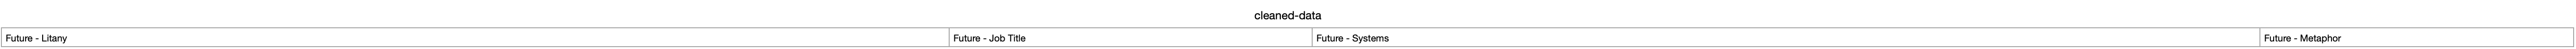

Use keyword count

In [4]:
litany = clean["Future - Litany"].dropna().tolist()
litany

['Co-facilitator with AI counterparts in highly personalized learning journeys for global citizens',
 'Climate change is terrible, but the effects are incremental. Something getting more wrong and worse every day, month, year, rather than in big catastrophic moves.',
 'This person is analysing data',
 'Trying to stem the tide of fake news and online vitriol',
 'this person is alone. sitting down on a chair. screens are all around. content displayed seems to be floating in the air. the person doesnt move. but the data being displayed changes along with her thoughts. she hears other voices in her head. those are other people interacting with her thoughts. thoughts are automatically categorised and summarised as the exchange of thought continues.',
 'Quiet and deliberating the next step of action as the whole world continues to fall into despair',
 'Scientific Expert at engineered intelligence in humans',
 'Motivating bots',
 'nothing',
 'User Experience Design',
 'They are a community or

In [5]:
job = clean["Future - Job Title"].dropna().tolist()
job

['Humentor (human-mentor)',
 'Climate Change Analyst',
 'Data manager',
 'Information specialist',
 'product manager',
 'Crisis coordinator / liberator',
 'Clone',
 'Productivity efficiency officer',
 'sensor',
 'Design interfaces for AI',
 'People architect',
 'creative',
 'Behavioural Architect',
 'NIL. Work is obsolete.',
 'Design advisor',
 'Customer Support Manager',
 'Designer',
 'Leadership and culture futurist',
 'Customiser',
 'Assistant Manager, Well-being',
 'Experience Designer',
 'Growth guide',
 'Ecosystem designer',
 'product strategist? i really am not sure',
 'Human Systems Design',
 'Experience creator',
 'Experience designer',
 'Network designer',
 'Reality designer',
 'Connector',
 'futures architect',
 'Strategic risk management consultant',
 'No change 😅',
 'Human behaviour analyst',
 'Telepathist',
 'Whole system enabler',
 'Teacher',
 'navigator',
 'Clinical Medical Tech',
 'Knowledge guardian',
 'Experience designer',
 'Professor?',
 'Development engineer',
 'G

In [6]:
system = clean["Future - Systems"].dropna().tolist()
system

['Symbiotic integration of humans and computers where learning is not anymore about learning lexical knowledge, but guiding empathetic futures',
 'Climate change has become an overriding thing',
 'Software has come to a point where it is fully autonomous. Work is mostly communication and presentations',
 'someone always has to be around to manage the software manifestations. even if it was cursory and most software development work is done by AI/ML',
 'The world is in a huge crisis as the environment, societies and political parties deteriorate. A lot of resources are being depleted e.g. water, food, energy, overwhelming waste and pollution. People are finding hard to live decent lives.',
 'A need to expound and expand on the human consciousness',
 'Lack need for human to human interactions. Ppl die from war. Choose to interact thru devices',
 'Greater need for customisation to meet individual needs',
 "Communal and collective living. Close integeation, collaboration prevails where com

In [7]:
metaphor = clean["Future - Metaphor"].dropna().tolist()
metaphor

['New era of augmented (virtual/biological) explorations',
 'Green is money',
 'A bee hive',
 'cant go out into the world. cant live for real.',
 'Can we find a way out of this?',
 'Unreal,',
 'Loneliness in wilderness',
 'The only limit is you',
 'Being is like a forest frog enjoying the trees',
 'new dawn',
 'The Truman Show',
 'Futuristic with a twist of colour.',
 'Garden cities',
 'Needle in a haystack',
 'A fork in the road',
 'Learning at speed',
 'A Time for Everything.',
 'We need happiness to be an evergreen state of being',
 'Out of this world',
 'Progress is water',
 'It takes a village',
 'Messy mix of blade runner, mad max, elysium',
 'Peace and tranquillity',
 'Possibilities like the boundless sky',
 'Collective data makes a collective decision',
 'You can be anything you want',
 'Living in a spiderweb',
 'technicoloured static on a shattered screen',
 'Ch Ch Ch changes',
 'Unmoored from time',
 'diversity is beauty',
 'Glossed over',
 'Dancing dolphins',
 'a fork in the

In [8]:
import spacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_infix_regex

nlp = spacy.load("en_core_web_sm")

def custom_tokenizer(nlp):
    inf = list(nlp.Defaults.infixes)               # Default infixes
    inf.remove(r"(?<=[0-9])[+\-\*^](?=[0-9-])")    # Remove the generic op between numbers or between a number and a -
    inf = tuple(inf)                               # Convert inf to tuple
    infixes = inf + tuple([r"(?<=[0-9])[+*^](?=[0-9-])", r"(?<=[0-9])-(?=-)"])  # Add the removed rule after subtracting (?<=[0-9])-(?=[0-9]) pattern
    infixes = [x for x in infixes if '-|–|—|--|---|——|~' not in x] # Remove - between letters rule
    infix_re = compile_infix_regex(infixes)

    return Tokenizer(nlp.vocab, prefix_search=nlp.tokenizer.prefix_search,
                                suffix_search=nlp.tokenizer.suffix_search,
                                infix_finditer=infix_re.finditer,
                                token_match=nlp.tokenizer.token_match,
                                rules=nlp.Defaults.tokenizer_exceptions)

nlp.tokenizer = custom_tokenizer(nlp)
doc = nlp('The Indo-European Caucus won the all-male election 58-32.')
print([token.text for token in doc]) 

['The', 'Indo-European', 'Caucus', 'won', 'the', 'all-male', 'election', '58-32', '.']


## Get tokens

In [9]:
def get_lemmas(text):
    try:
        doc = nlp(text)
        lemmas = []
        for token in doc:
            if not token.is_punct and token.lemma_ != "-" and not token.is_stop:
                if len(token.lemma_.strip("\n\n")) > 1:
                    lemmas.append(token.lemma_.lower().strip("\n\n"))
        return lemmas
    except:
        return []

#     Future - Litany
# Future - Job Title
# Future - Systems
# Future - Metaphor
# clean["litany_tokens"] = 
clean['litany_tokens'] = clean.apply(lambda r: get_lemmas(r["Future - Litany"]), axis=1)
clean['job_tokens'] = clean.apply(lambda r: get_lemmas(r["Future - Job Title"]), axis=1)
clean['system_tokens'] = clean.apply(lambda r: get_lemmas(r["Future - Systems"]), axis=1)
clean['met_tokens'] = clean.apply(lambda r: get_lemmas(r["Future - Metaphor"]), axis=1)
clean

,id,Preferred Name,Industry,Job Title,Job Tags,Job Description,STEEP Change 1,STEEP Change 2,STEEP Change 3,STEEP Combined,...,Future - Job Title,Future - Systems,Future - Metaphor,Feedback,How got to know,tags,litany_tokens,job_tokens,system_tokens,met_tokens
0,6202786c7d40bb363a40f8e8,Nicole,Design / construction,Interior designer,design,I design residential interior spaces,Environmental,Technological,Social,"Environmental,Technological,Social",...,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[],[]
1,622008119cedee53316e89a5,Tamas,Education,Professor,education,I teach at a university,Technological,Economic,Environmental,"Technological,Economic,Environmental",...,Humentor (human-mentor),Symbiotic integration of humans and computers ...,New era of augmented (virtual/biological) expl...,NaN,Khai Seng’s LinkedIn post,Reflections yes,"[co-facilitator, ai, counterpart, highly, pers...","[humentor, human-mentor]","[symbiotic, integration, human, computer, lear...","[new, era, augment, virtual, biological, explo..."
2,621ec40f51220c43431eeed7,Eddie,Education,Researcher,"education,research",I read and write a lot.,Social,Technological,Environmental,"Social,Technological,Environmental",...,Climate Change Analyst,Climate change has become an overriding thing,Green is money,NaN,A friend forwarded the chatbot to me,Reflections yes,"[climate, change, terrible, effect, incrementa...","[climate, change, analyst]","[climate, change, override, thing]","[green, money]"
3,621d65d80cd62d17365b1b01,Rashid,Education,Instructor,education,Moulding young minds,Technological,Economic,Social,"Technological,Economic,Social",...,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[],[]
4,621debc675b8ef017c0797ff,Melissa,Civil Service,SSO Organisation Review,public service,Formulate & implement Organisation Development...,Technological,Environmental,Economic,"Technological,Environmental,Economic",...,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,62217153b3309273de44dc59,Gayatri,Technology,Head of Product,tech,I solve customer problems which benefits all i...,Social,Environmental,Political,"Social,Environmental,Political",...,"Oh work wise. Titles are mess now, I want to s...",I am biased that Product role brings much need...,Zindagi na milegi dobara (translation. Live li...,Bye,From Tamas M. - my favorite colleague and UX r...,NaN,"[evening, timezone, assume, person, location, ...","[oh, work, wise, title, mess, want, well, unde...","[biased, product, role, bring, need, customer,...","[zindagi, na, milegi, dobara, translation, liv..."
134,621e04eb4bfec76537476c40,kaz,FinTech,UX Research Lead,"finance,research",I provide research insights to a FinTech compa...,Environmental,Social,Technological,"Environmental,Social,Technological",...,Research Insights?,More digital solutions,An open book,NaN,NaN,NaN,"[research, 2100, context]","[research, insight]","[digital, solution]","[open, book]"
135,6241892a313b91718b6e8569,Tuskoriented,Government,Designer,"public service,design",I help to make life better for Singaporeans by...,Economic,Environmental,Technological,"Economic,Environmental,Technological",...,Resource and Allegiance Coordinator,After the proliferation of data and wealth in ...,The world is a tapestry that’s resolving itsel...,NaN,DesignSG group + Linkedin!,NaN,"[person, try, hard, secure, resource, need, su...","[resource, allegiance, coordinator]","[proliferation, datum, wealth, 2000, earth, hi...","[world, tapestry, resolve, series, tangle, tas..."
136,6242fdd5f688c34ea219ef28,Mel,Government,Strategic planning executive,public service,"Help my organisation plan for the future, and ...",Social,Environmental,Economic,"Social,Environmental,Economic",...,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[],[]


In [34]:
clean.to_csv("data/cleaned-data-tokens.csv")

In [10]:
def get_counts(series):
    flattened = [val for sublist in series for val in sublist]
    counter_object = Counter(flattened)
    return pd.DataFrame({"key": counter_object.keys(), "value": counter_object.values()}).sort_values("value")

lit = get_counts(clean["litany_tokens"])

In [11]:
jt = get_counts(clean["job_tokens"])
st = get_counts(clean["system_tokens"])
mt = get_counts(clean["met_tokens"])

In [12]:
jt

,key,value
0,humentor,1
106,transformation,1
107,calm,1
108,energy,1
109,ironmonger,1
...,...,...
22,architect,5
44,human,5
54,consultant,5
6,manager,7


In [13]:
mt

,key,value
202,play,1
109,super,1
110,computer,1
179,means,1
112,race,1
...,...,...
162,work,4
20,like,5
12,live,5
11,world,8


In [14]:
st

,key,value
0,symbiotic,1
491,facetime,1
492,mandatory,1
494,mundane,1
495,labour,1
...,...,...
13,change,18
21,work,22
2,human,25
48,people,33


In [15]:
lit.to_csv("data/litany-data.csv")
jt.to_csv("data/job-title-data.csv")
mt.to_csv("data/metaphor-data.csv")
st.to_csv("data/symbols-data.csv")

In [24]:
import spacy
nlp = spacy.load("en_core_web_sm")

doc = nlp("Cloud computing is benefiting major manufacturing companies")
list(doc.noun_chunks)

/usr/local/lib/python3.9/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


[Cloud computing, major manufacturing companies]

In [33]:
doc = nlp(system[19])
list(doc.noun_chunks)

[People,
 their sense,
 purpose,
 the things,
 they,
 snd,
 order,
 the work,
 they,
 they,
 the time,
 their own growth,
 career,
 development,
 This job,
 them,
 they,
 work]

In [26]:
for noun_phrase in list(doc.noun_chunks):
    print(noun_phrase.root.tag_, noun_phrase.root.lemma_, noun_phrase.root.ent_type_)

[(token.text,token.pos_) for token in doc]

NN computing 
NNS company 


[('Cloud', 'PROPN'),
 ('computing', 'NOUN'),
 ('is', 'AUX'),
 ('benefiting', 'VERB'),
 ('major', 'ADJ'),
 ('manufacturing', 'NOUN'),
 ('companies', 'NOUN')]

## Add sentiment

In [17]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("Wow, NLTK is really powerful!")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bianchi_dy/nltk_data...


{'neg': 0.0, 'neu': 0.295, 'pos': 0.705, 'compound': 0.8012}

In [21]:
k=10
sia.polarity_scores(litany[k])

{'neg': 0.0, 'neu': 0.766, 'pos': 0.234, 'compound': 0.7506}

In [22]:
litany[k]

'They are a community oriented person, their purpose is empowering people through profession. They collaborate with a team, they help set peoplr up for success'